In [51]:
what_were_covering = {1: 'data (prepare and load)',
                      2: 'build model',
                      3: 'fit the model(training)',
                      4: 'make predictions (inference)',
                      5: 'Save and load a model',
                      6: 'Putting all together'}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fit the model(training)',
 4: 'make predictions (inference)',
 5: 'Save and load a model',
 6: 'Putting all together'}

In [52]:
import torch
from torch import nn # nn contains all pytorch's building blocks for neural networks
import matplotlib.pyplot as plt


torch.__version__

'2.1.0+cu121'

## 1. Data (Preparing and Loading)

Machine Learning has two parts:
1. Get data into numerical representation
2. Build a model to find patterns in that numerical representation


In [53]:
## Create some "known" data using linear regression
## We will use a linear reg formula to make a straight line with known
## parameters


In [54]:
# Create "known" parameters
weight=0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)  #input
y= weight *X + bias                                # output


In [55]:
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [56]:
len(X),len(y)

(50, 50)

In [57]:
# Split the data into train and test data

In [58]:
train_split = int(0.8*len(X))  # 0.8 becoz 80% of data is for training
X_train, y_train = X[:train_split], y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]


In [59]:
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [60]:
# build a function to visualize the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  """
  Plots training and testing data and compares predictions
  """

  plt.figure(figsize=(10,7))

  #Training data in blue
  # c-->color, s-->size
  plt.scatter(train_data,train_labels,c='b',s=4,label="Training data")

  #testing data in green
  plt.scatter(test_data,test_labels,c='g',s=4,label="Testing data")

  #Are there predictions
  if predictions is not None:

    # plot the predictions if exist
    plt.scatter(test_data,predictions,c='r',s=4,label="Predictions")

  plt.legend(prop={"size":14});

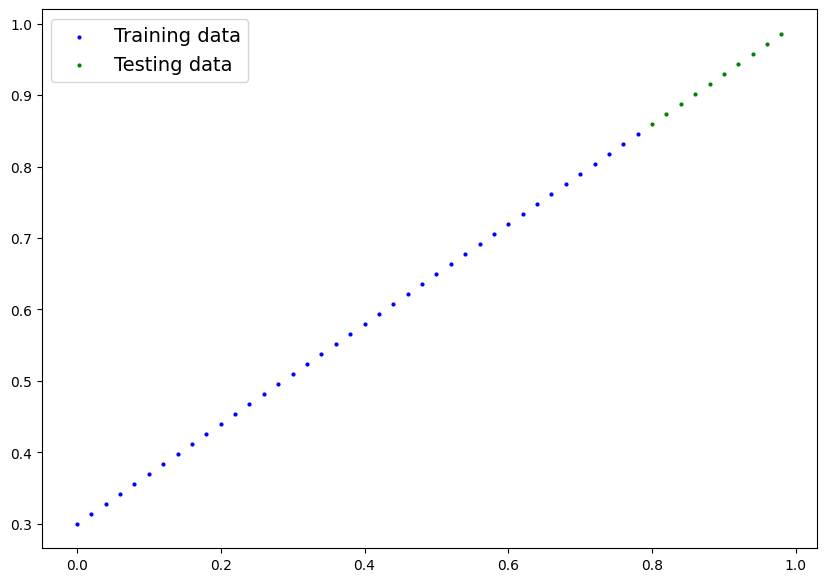

In [61]:
plot_predictions()

## 2. Build Model

In [62]:
from torch import nn

What our model does:
1. Start with random numbers
2. Based on training data, adjust the random values to better represent the ideal values(values we used to create the data)

How does it do?
1. Gradient Descent
2. Backpropagation

In [63]:
class LinearRegressionModel(nn.Module):
   # LinearRegressionModel is inherited from nn module
    def __init__(self):
      super().__init__()

    # Initialize model parameters
      self.weight = nn.Parameter(torch.randn(1,
                                            requires_grad=True,  # Can this parameter be updated through gradient descent? (If yes,)
                                            dtype=torch.float))
      self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    # forward() (linear regression function) method to define the computation in the model
    def forward(self,x: torch.Tensor) -> torch.Tensor: # x is input
      return self.weight * x + self.bias


### Pytorch essentials

* torch.nn
* torch.nn.Parameter - what params our model should learn and try, often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - Base class for all neural network modules
* torch.optim
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [64]:
torch.manual_seed(42)

# create an instance of model
model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [65]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [66]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [67]:
# list named parameters

## In PyTorch, the learnable parameters (i.e. weights and biases) of a torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()).
## A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions using torch.inference_mode()

To check the model's predictive power, we can see how well it predicts y_test based on x_test

When we pass data via our model, it's going to run through forward()

In [68]:
# torch.inference_mode()-context manager : with this mode, gradients are not tracked i.e., we don't keep track
# of how we update our models, we can make predictions faster (as gradients are not tracked)

with torch.inference_mode():
    y_preds = model_0(X_test)

In [69]:
y_preds,y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

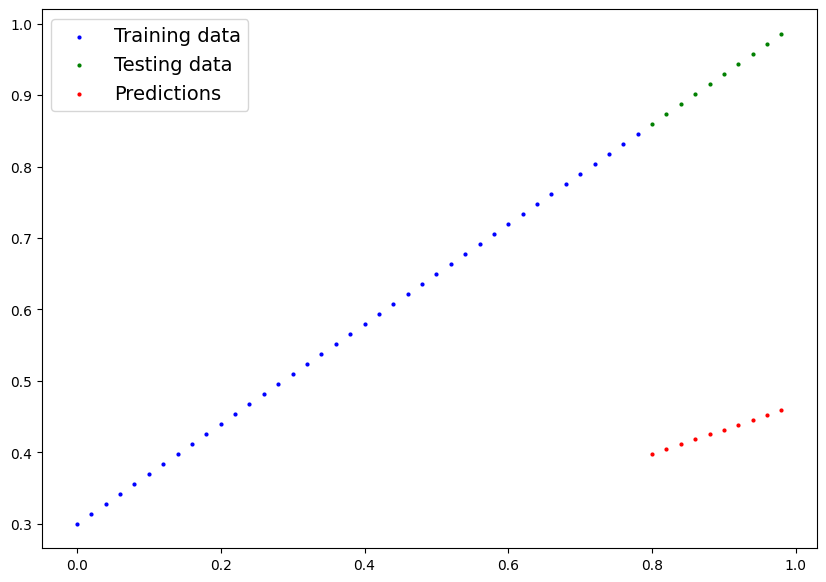

In [70]:
plot_predictions(predictions=y_preds)

## 3. Train the Model

Things we need:

**Loss function**: pred - actual

**Optimizer** : consider loss and adjust model's param to improve loss function

For pytorch, we need:
1. A training loop
2. A testing loop

In [71]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [72]:
# Setup a loss function
loss_fn = nn.L1Loss()  # MAE

# Setup an optimizer (Stochastic Gradient Descent)
# It starts by randomly adjusting the above weight and bias values and
# once it found values that has lower MAE or loss , it will continue with that weights
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate

In [73]:
optimizer,loss_fn

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 L1Loss())

### Building a training loop and a testing loop

For training loop:
0. Loop through the data
1. Forward Pass/forward Propagation (invloves data moving through our model's forward function to make predictions)
2. Calculate Loss (Actual - Predictions)
3. Optimizer
4. Loss backward - backward propagation
(calc gradients of each of params w.r.t to loss)
5. Optimizer step - adjust weights (gradient descent)

In [74]:
torch.manual_seed(42)
# epoch is one loop through data
epochs = 100  # hyperparameter

# To track diff values
epoch_count=[]
train_loss_values=[]
test_loss_values=[]
### Training


# 0. Loop through the data
for epoch in range(epochs):
  model_0.train() # enables requires grad for parameters which requires grad

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate Loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer
  ## Zero the gradients of Optimizer (as they accumulate to every epoch, we need zero them to start fresh
  ## for every epoch )
  optimizer.zero_grad()

  # 4. Loss backward - backpropagation
  loss.backward()

  # 5. Optimizer step - adjust weights
  ## Progress/Step the optimizer
  optimizer.step()

  ### Testing
  model_0.eval() # turns off diff settings  i.e., not needed for evaluation
  with torch.inference_mode():
      # turns off gradient tracking
      # 1. forward pass
      test_pred = model_0(X_test)

      # 2. Calc the loss
      test_loss = loss_fn(test_pred,y_test.type(torch.float))

  if epoch % 10 ==0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print our model state_dict()
    #print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819


In [75]:
weight,bias

(0.7, 0.3)

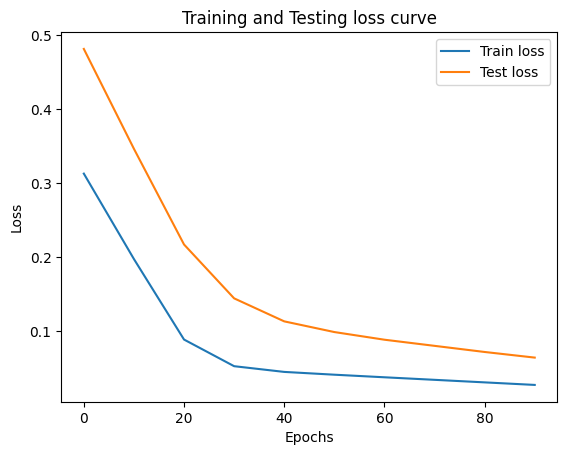

In [76]:
# plot loss curves
plt.plot(epoch_count,train_loss_values, label="Train loss")
plt.plot(epoch_count,test_loss_values, label="Test loss")
plt.title("Training and Testing loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [77]:
# Our loss values are still as tensors but matplotlib wont work with tensors, so we should convert it to numpy

In [78]:
import numpy as np

In [79]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

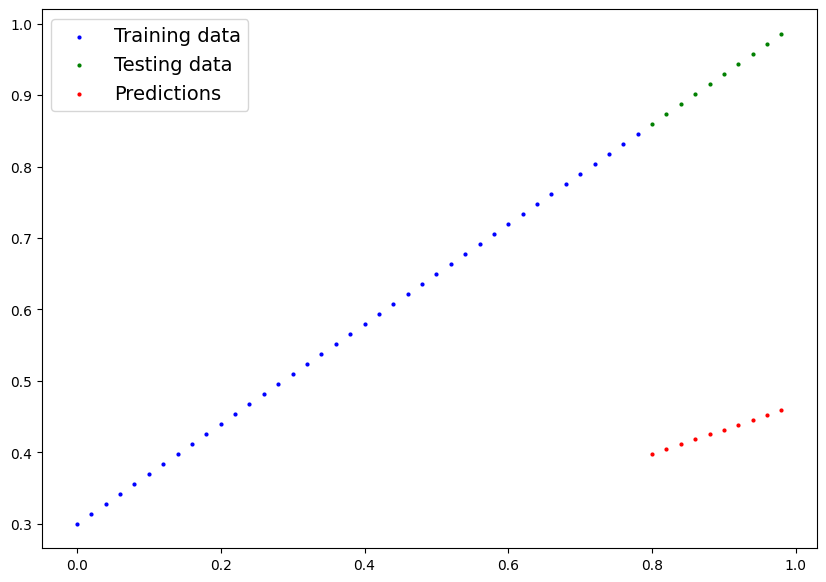

In [80]:
plot_predictions(predictions=y_preds)

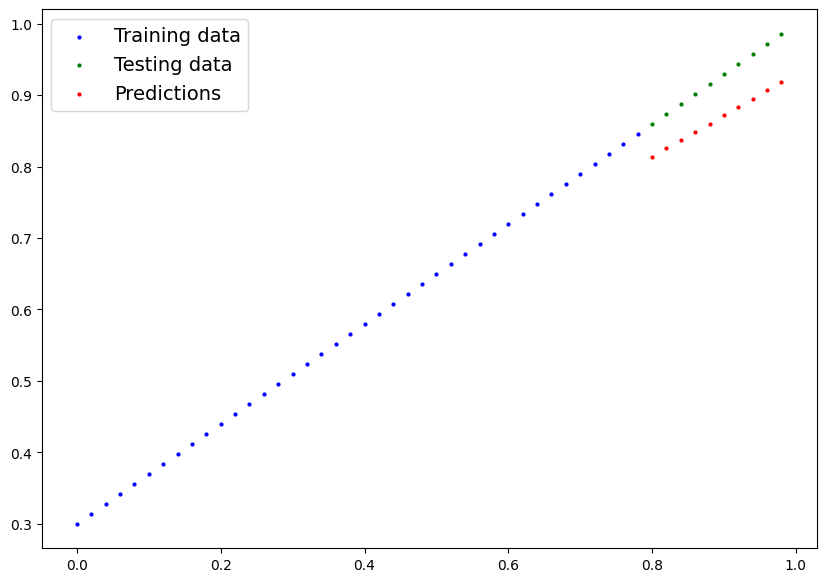

In [84]:
plot_predictions(predictions=y_preds_new)

## Saving a model in Pytorch

Three main methods for saving and loading:

1. torch.save()
2. torch.load()
3. torch.nn.Module.load_state_dict() - allows you to load model's saved state dict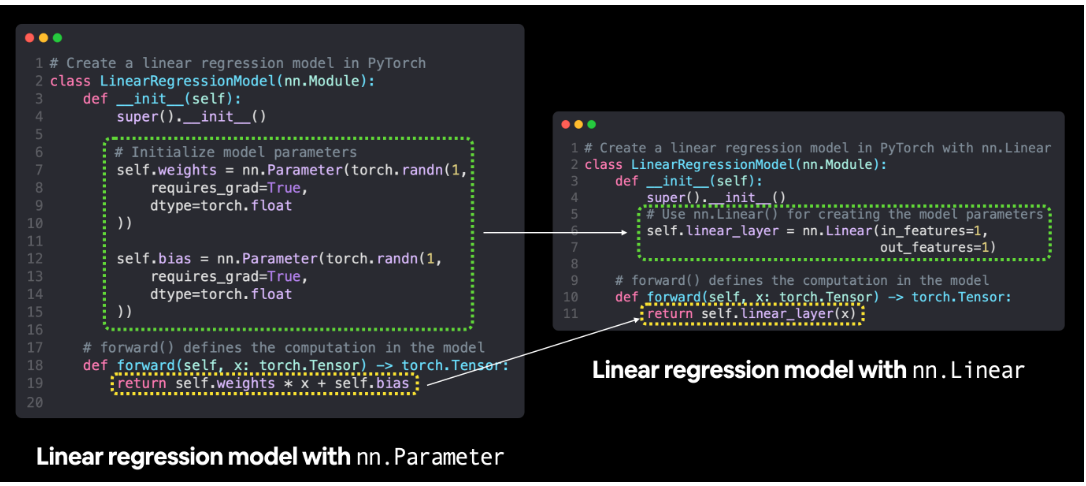

In [87]:
# Saving model
# pytorch objects have extension .pth while saving

from pathlib import Path

# 1. Create model's directory
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
model_name = "Pytorch Workflow model_0.pth"
model_save_path = model_path/model_name

model_save_path

# 3. Save the model's state_dict
torch.save(obj=model_0.state_dict(),
           f=model_save_path)
print("Saving model to ", model_save_path)

Saving model to  models/Pytorch Workflow model_0.pth


In [88]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1662 Feb  4 05:12 'Pytorch Workflow model_0.pth'


In [90]:
# Loading model
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=model_save_path))

<All keys matched successfully>

In [92]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [91]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [93]:
# predictions

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [95]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all Together

In [96]:
import torch
from torch import nn
import matplotlib.pyplot as plt


Setup device agnostic code

This means:
If you've got access to a GPU, the above should've printed out:

Using device: cuda
Otherwise, you'll be using a CPU for the following computations. This is fine for our small dataset but it will take longer for larger datasets.

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device",device)

Using device cpu


### 6.1 Data

In [99]:
# Create some data using Linear regression formula
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [100]:
# split data
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

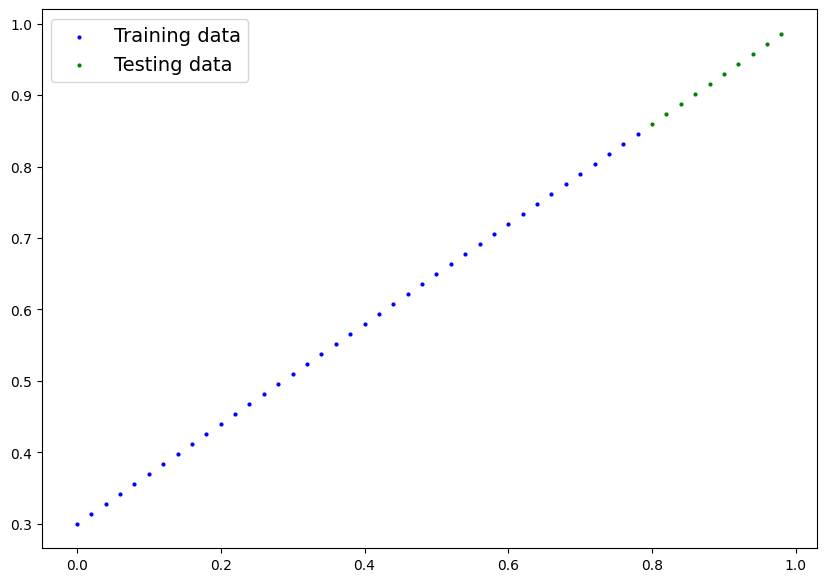

In [101]:
# plot
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Build a linear model

In [102]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize layers that have parameters in built
    # use nn.Linear() for creating model params
    # also called linear transform, probing layer,dense layer, fully connected layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)  # i.e., one values of x (in_features) points to one values of y(out_features)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

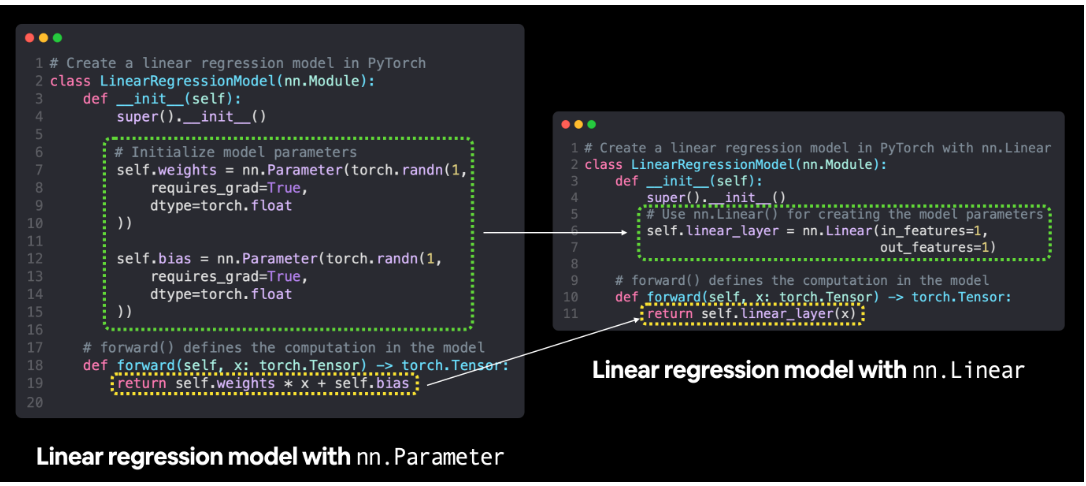

### 6.3 Training the model


We need:
1. loss function
2. optimizer
3. training loop
4. test loop

In [104]:
loss_fn= nn.L1Loss()

optim = torch.optim.SGD(lr=0.01,
                        params=model_1.parameters())

In [107]:
# training looop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  # forward pass
  y_pred = model_1(X_train)

  # loss
  loss=loss_fn(y_pred,y_train)

  optim.zero_grad()
  #backpropagation
  loss.backward()

  optim.step()

  # testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred,y_test)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.01380180753767

In [108]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [109]:
# Predictions

In [110]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds


tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

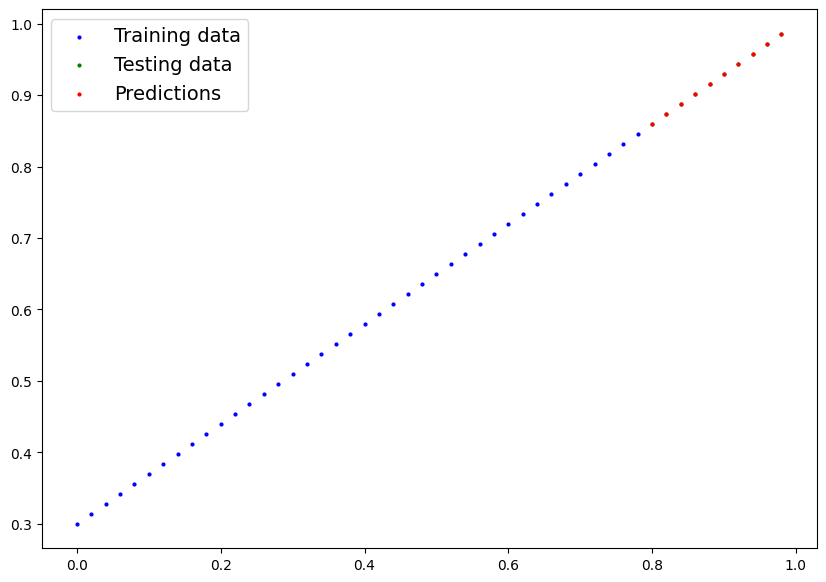

In [111]:
plot_predictions(predictions =y_preds)

In [ ]:
## continue with saving and loading